In [157]:
import requests
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from os import path

In [188]:
def datamuse(query):
    # http://www.datamuse.com/api/
    url = "https://api.datamuse.com/words?ml=" + query + "&max=75" #max = number of results to return
    response = requests.get(url)
    similar_words = [x['word'] for x in json.loads(response.content)]
    return similar_words

In [189]:
def mc28():
    with open('datasets/sim-eval-master/datasets/mc.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        rows = []
        for row in reader: rows.append(row)
        return rows # [[word1, word2, similarity], ...] 
    
def load_dataset(name):
    with open('datasets/sim-eval-master/datasets/{name}.csv'.format(name=name), newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        rows = []
        for row in reader: rows.append(row)
        return rows # [[word1, word2, similarity], ...] 

# SN is classification data




In [190]:
def stss131():
    # https://www.researchgate.net/publication/262411640_A_new_benchmark_dataset_with_production_methodology_for_short_text_semantic_similarity_algorithms
    with open('datasets/stss-131/stss.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        rows = []
        for row in reader: rows.append(row)
        return rows # [[index, sentence1, sentence2, avg similarity, standard deviation], ...]

In [191]:
def jaccard(word_list1, word_list2):
    intersection = len(set(word_list1).intersection(word_list2))
    union = len(set(word_list1).union(word_list2))
    jaccard_similarity = intersection / union
    return jaccard_similarity

In [192]:
from functools import reduce, partial
from itertools import starmap

def get_ml(w,c):
    """ Get a function for querying the related words """
    return [lambda: datamuse(
       "{word}&max={count}"
       .format(word=w,count=c)
    ), w]

def relations_to_file(fn, word):
    """
    fn: query function
    word
    """
    filename = "./related-words/{}.ml".format(word)
        
    with open(filename, 'w') as f:
        """ 
        Query the related words one at a time 
        when required for writing to file 
        """
        for word in fn():
            f.write(word)
            f.write('\n')
            
    return filename

def collect_ml_getters(dataset_fn, count=100):
    """ Collect the getters for lazy evaluation """
    return reduce(lambda acc, fns: acc + fns, [
        [get_ml(f,count), get_ml(s,count)]
        for f, s, _ 
        in dataset_fn()
    ], [])

def get_and_write_dataset_words_to_files(dataset_fn, count=30):
    """works for files that return tuple with three items per row"""
    return list(starmap(
        relations_to_file, 
        collect_ml_getters(dataset_fn, count)
    ))

# write the files with
# get_and_write_dataset_words_to_files(mc28, count=100)




In [193]:
wordsim = lambda: load_dataset('wordsim')
debug_val = collect_ml_getters(wordsim, count=1)


In [85]:
def plussaa(accumulator, variable):
    print(accumulator)
    print(variable)
    return accumulator + variable

reduce(
    # functio (accumulator, iterator)
    plussaa, 
    # iterator take a valua one at a time
    ["h","e","i"],
    # Accumulator for the first round
    ""
)


h
h
e
he
i


'hei'

Text(0, 0.5, 'Correlation')

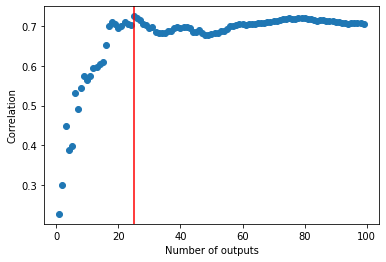

In [194]:
# We would like to test the similarity between the pair (X,Y) by using the output of the Datamuse API 
# for both X and Y. Set the number of outcome words in the API to be large, e.g., 30. Use Jaccard similarity 
# to compute the similarity between X and Y (Counting the ratio of common words among the outputs of X and Y 
# Datamuse API over the total number of distinct words in the two outputs).
#
# Repeat this process of calculating the similarity between each pair in MC-28 dataset, and then calculate the
# correlation coefficient with the human judgment using Pearson coefficient. 
# Try to optimize the parameters ofd atamuse API call by testing distinct number of outputs and monitor the 
# value of the correlation until you reach
# the highest correlation value. 

mc = np.array(mc28())


def load_from_file(word):
    with open('./related-words/'+word+'.ml', 'r') as f:
        return np.array([ l.replace("\n", "") for l in f])        

def calc_correlation(data):
    def f(number_of_outputs):
        get_rel_words = lambda word: load_from_file(word)

        similarity = lambda row: jaccard(
            get_rel_words(row[0])[:number_of_outputs], 
            get_rel_words(row[1])[:number_of_outputs]
        )

        datamuse_similarity = np.apply_along_axis(similarity, 1, data)
        ground_truth = data.transpose()[2].astype(np.float)
        return pearsonr(datamuse_similarity, ground_truth)[0]
    
    return f


n = np.arange(1, 100, 1)

corr = np.vectorize(calc_correlation(mc))(n)

plt.scatter(n, corr)
plt.axvline(x=n[np.argmax(corr)], color="red")
plt.xlabel("Number of outputs")
plt.ylabel("Correlation")

# Use this configuration to calculate the correlation value for other datasets, and 
# compare the result with other state-of-art results as reported in relevant literature (e.g., previous sim-eval 
# repository) .

In [141]:
wordsim = load_dataset('wordsim')

uniq_wordsim = set(reduce(lambda x,y: x + y, [ [a,b] for a,b,x in wordsim ], []))
collected_getters = [get_ml(w, 25) for w in list(uniq_wordsim)]

In [151]:
def get_ml_to_file(wordlist):
    collected_getters = [get_ml(w, 25) for w in list(wordlist)]
    list(starmap(relations_to_file, collected_getters))

def load_unique_words_to_file(name):
    uniq_wordsim = set(reduce(lambda x,y: x + y, [ [a,b] for a,b,x in load_dataset(name) ], []))
    get_ml_to_file(uniq_wordsim)


In [145]:
load_unique_words_to_file('rg')

Text(0, 0.5, 'Correlation')

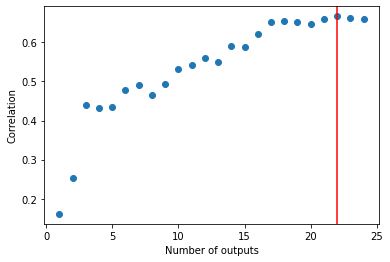

In [154]:
n = np.arange(1, 25, 1)

corr = np.vectorize(calc_correlation(np.array(load_dataset('rg'))))(n)

plt.scatter(n, corr)
plt.axvline(x=n[np.argmax(corr)], color="red")
plt.xlabel("Number of outputs")
plt.ylabel("Correlation")


## Load word vectors from Glove dataset

In [319]:
import glove

In [320]:
# Available glove datasets
glove.GLOVE_DATASETS

{'100d': '/home/tvaisanen/CSE/natural-language-processing/nlp-project-13/datasets/glove.6B/glove.6B.100d.txt',
 '50d': '/home/tvaisanen/CSE/natural-language-processing/nlp-project-13/datasets/glove.6B/glove.6B.50d.txt',
 '300d': '/home/tvaisanen/CSE/natural-language-processing/nlp-project-13/datasets/glove.6B/glove.6B.300d.txt',
 '200d': '/home/tvaisanen/CSE/natural-language-processing/nlp-project-13/datasets/glove.6B/glove.6B.200d.txt'}

In [321]:
# Select the dataset
ds = glove.GLOVE_DATASETS['50d']

In [323]:
# Load the dataset to pandas dataframe
words = glove.load_words(ds)

In [324]:
# Get one
# words.loc['morning']

In [325]:
# Get multiple
words.loc[['morning','peth']]

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,,,,,,,,,,,,,,,,,,,,,
morning,0.12099,0.10119,-0.18065,0.20052,0.34682,-1.06040,-1.164700,0.64395,-0.33524,-0.790360,...,-0.44613,0.36396,-0.53107,-0.38338,0.63936,-0.079852,0.04625,-0.20362,0.41999,0.25573
peth,0.13204,-0.92612,-0.10671,-0.11890,-0.34822,0.60301,-0.082492,-1.33460,0.76390,0.052326,...,0.34490,-0.22698,-0.88790,-0.51040,0.66471,0.508140,0.84586,-0.42389,1.05070,0.18619


## Sentence Level Work

In [326]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize


data = pd.DataFrame(stss131(), columns=['0', 's1','s2','3','4'])
data

,0,s1,s2,3,4
0,66,Would you like to go out to drink with me toni...,I really don't know what to eat tonight so I m...,1.01,0.77
1,67,I advise you to treat this matter very serious...,"You must take this most seriously, it will aff...",3.38,0.69
2,68,When I was going out to meet my friends there ...,The train operator announced to the passengers...,3.13,0.68
3,69,"Does music help you to relax, or does it distr...",Does this sponge look wet or dry to you?,0.1,0.29
4,70,You must realise that you will definitely be p...,He will be harshly punished for setting the fi...,2.84,0.87
...,...,...,...,...,...
61,127,We often ran to school because we were always ...,I knew I was late for my class so I ran all th...,3.1,0.85
62,128,"I hope you're taking this seriously, if not yo...",The difficult course meant that only the stron...,0.5,0.87
63,129,"The shores or shore of a sea, lake or wide riv...",An autograph is the signature of someone famou...,0.11,0.43
64,130,"I bought a new guitar today, do you like it?",The weapon choice reflects the personality of ...,0.16,0.34


In [327]:
stss131_all_sentences = data[:]['s1'] + data[:]['s2']


In [328]:
def get_all_tokens(list_of_sentences):
    return reduce(
            lambda a,t: a +t, 
            [word_tokenize(s) 
             for s 
             in all_sentences],
            []
        )

In [329]:
stss131_uniq_tokens = list(
    set(reduce(
        lambda a,w: a+w,
        [
            w.split('.') 
            for w 
            in get_all_tokens(stss131_all_sentences)], 
        []
    )
))


In [330]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.snowball.SnowballStemmer('english')

In [331]:
a = set(stss131_uniq_tokens)
b = set(stopwords)
stss131_without_stopwords = list(a.difference(b))

In [332]:
import re 
def clean_token(word):
    clean1 = re.sub('^[^a-zA-Z]*', "", word)
    return re.sub('[^a-zA-Z]*$', "", clean1).lower()

In [333]:
clean_token("+hEEllo")


'heello'

In [334]:
[w for w in stss131_without_stopwords if len(w) < 3 and w != 'I']

['',
 'In',
 'A',
 "'m",
 'My',
 "'s",
 '–I',
 'ca',
 'Is',
 '0',
 '12',
 'us',
 'We',
 "'d",
 'C',
 'Do',
 '?',
 ',',
 '’',
 'If',
 'It',
 'He',
 'An',
 'go']

In [335]:
cleaned_tokens = [clean_token(w) for w in stss131_without_stopwords]
cleaned_without_empty = [w for w in cleaned_tokens if len(w) > 0]
duplicates_removed = list(set(cleaned_without_empty))

In [396]:
import os
downloaded = set([w.replace('.ml', '').lower() for w in os.listdir('./related-words')])
stss131_unique_cleaned_tokens = list(
    set(duplicates_removed).difference(set(downloaded)).difference(set(stopwords)))

In [397]:
get_ml_to_file(stss131_unique_cleaned_tokens)

In [404]:
def tokenize_sentence(sentence, stopwords):
    tokens = [w for w in [clean_token(t) for t in word_tokenize(sentence)] if len(w) > 0]
    #return tokens
    return list(set(tokens).difference(stopwords))

In [405]:
s1 = tokenize_sentence(data.iloc[0]['s1'], stopwords)
s2 = tokenize_sentence(data.iloc[0]['s2'], stopwords)
s1

['would', 'drink', 'tonight', 'like', 'go']

In [416]:

def pad_a(arr, c=25, padwith=None):
    if (len(arr) == 25):
        return arr
    else:
        return np.array(arr) + np.array([padwith]) * (c-len(arr))


d = [(w,related) for w, related in [(w,load_from_file(w)) for w in s1+s2]]

df = pd.DataFrame(dict(list(filter(lambda v: len(v[1]) != 0, d))))

df

,would,drink,tonight,like,go,know,eat,somewhere,really,might
0,ought,alcohol,this evening,ish,get,recognize,consume,someplace,very,could
1,dare,booze,this night,similar,move,acknowledge,feed,anywhere,actually,can
2,expected,beverage,night,wish,proceed,love,deplete,nowhere,truly,mightiness
3,wish,alcoholic beverage,evening,same,run,cognize,corrode,where,genuinely,power
4,gonna,imbibe,today,alike,turn,screw,wipe out,sometime,real,possibly
5,never,boozing,afternoon,comparable,start,live,run through,something,rattling,perhaps
6,oughta,drunkenness,wednesdays,suchlike,live,eff,exhaust,somehow,forsooth,probably
7,only,drinkable,dinner,care,work,hump,rust,there,in truth,ought
8,wanna,intoxicant,sundown,equivalent,pass,experience,eat on,here,obviously,maybe
9,council,potable,nightfall,equal,travel,bang,eat up,elsewhere,definitely,likely


In [409]:
def sentence_dm_repr(s, df):
    # sentence as datamuse representation
    return list(reduce(lambda a,v: a+v, df[s].values.tolist(), []))

def compare_sentence_dm_repr(s1,s2,df):
    return jaccard(sentence_dm_repr(s1,df),sentence_dm_repr(s2,df))
    

In [392]:
compare_sentence_dm_repr(s1,s2,df)

ZeroDivisionError: division by zero

In [361]:


def pad_a(arr, c=25, padwith=None):
    return np.array(arr) + np.array([padwith]) * (c-len(arr))




In [362]:
ex = [1,2,3,4,5,6,7,8,9,3,4,6,6,3]
c = 25

result = pad_array(ex)

In [363]:
result

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 3,
 4,
 6,
 6,
 3,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [346]:

def pad_a(arr, c=25, padwith=None):
    return arr + [padwith] * (c-len(arr))


In [347]:
pad_a([1,2])

[1,
 2,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]